In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
import warnings

In [2]:
import nltk

In [3]:
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

In [4]:
characters = pd.read_csv('simpsons_characters.csv', index_col='id').sort_index()
lines = pd.read_csv('simpsons_script_lines.csv', 
                    index_col='id', error_bad_lines=False).sort_index()

In [252]:
characters.head()

,name,normalized_name,gender
id,,,
1,Marge Simpson,marge simpson,f
2,Homer Simpson,homer simpson,m
3,Seymour Skinner,seymour skinner,m
4,JANEY,janey,f
5,Todd Flanders,todd flanders,m


In [253]:
#characters[characters['normalized_name'].str.contains('homer')][:30]
characters.loc[[125, 625, 1011, 1085, 2408], ['name']]

,name
id,
125,Homer's Canyon Echo
625,Homer-Ape
1011,Homer's Bloody Skull
1085,Evil Homer
2408,Homer's Stomach


In [254]:
lines.drop(['number', 'timestamp_in_ms', 'raw_text', 'normalized_text'], axis=1).head()

,episode_id,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,word_count
id,,,,,,,,
1,1,FALSE,NaN,1.0,NaN,Street,NaN,NaN
2,1,FALSE,NaN,2.0,NaN,Car,NaN,NaN
3,1,TRUE,1,2.0,Marge Simpson,Car,"Ooo, careful, Homer.",3
4,1,TRUE,2,2.0,Homer Simpson,Car,There's no time to be careful.,6
5,1,TRUE,2,2.0,Homer Simpson,Car,We're late.,2


In [255]:
lines.drop(['number', 'timestamp_in_ms', 'raw_text'], axis=1).groupby('raw_character_text').count().sort_values(by='normalized_text', ascending=False)[:10]

,episode_id,speaking_line,character_id,location_id,raw_location_text,spoken_words,normalized_text,word_count
raw_character_text,,,,,,,,
Homer Simpson,29842,29842,29842,29772,29772,27912,27909,27912
Marge Simpson,14158,14158,14158,14134,14134,13192,13190,13192
Bart Simpson,13777,13777,13777,13763,13763,13013,13011,13013
Lisa Simpson,11502,11502,11502,11485,11485,10769,10767,10769
C. Montgomery Burns,3172,3172,3172,3172,3172,3087,3086,3087
Moe Szyslak,2864,2864,2864,2862,2862,2810,2810,2810
Seymour Skinner,2443,2443,2443,2438,2438,2390,2390,2390
Ned Flanders,2145,2145,2145,2141,2141,2057,2056,2057
Grampa Simpson,1886,1886,1886,1881,1881,1807,1807,1807


In [256]:
lines.loc[(lines.raw_character_text == 'Homer Simpson') & (lines.word_count.isnull()), ['raw_text', 'raw_character_text', 'spoken_words']][:5]

,raw_text,raw_character_text,spoken_words
id,,,
123,Homer Simpson: (SHRIEKS),Homer Simpson,NaN
187,Homer Simpson: (SHUDDERS),Homer Simpson,NaN
324,Homer Simpson: (GROANS LIKE HE'S HAVING A HEAR...,Homer Simpson,NaN
328,Homer Simpson: (GROAN),Homer Simpson,NaN
612,Homer Simpson: (GRUNTS),Homer Simpson,NaN


In [257]:
top_50 = lines.groupby('raw_character_text')['raw_text'].count().sort_values(ascending=False)[:50]
top_50.to_csv('top_50.csv')

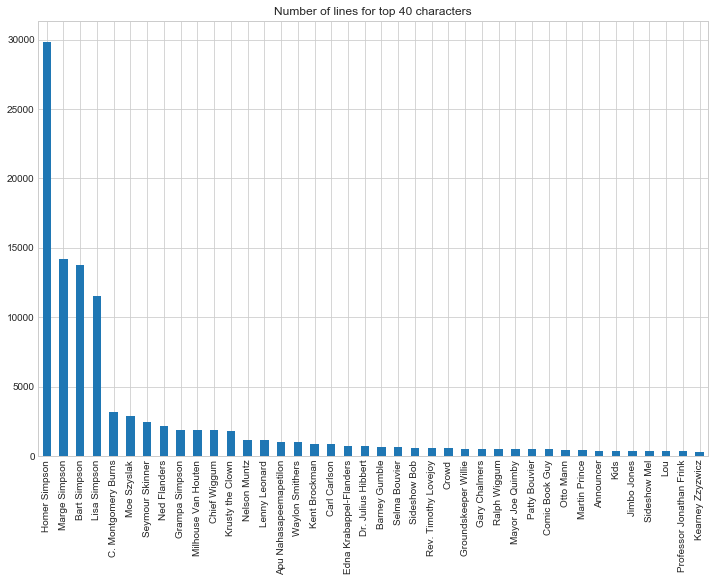

In [258]:
fig, ax = plt.subplots(figsize=(12, 8))
lines.groupby('raw_character_text')['raw_text'].count().sort_values(ascending=False)[:40].plot(kind='bar')
ax.set_title('Number of lines for top 40 characters')
ax.set_xlabel('');

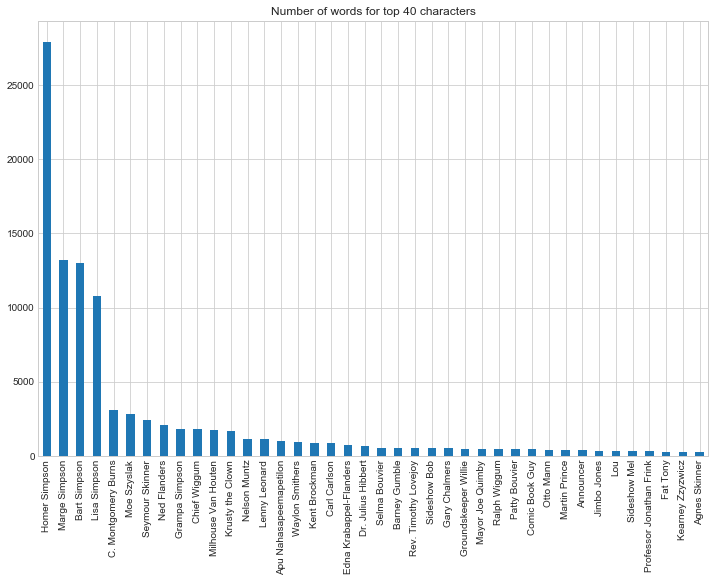

In [259]:
fig, ax = plt.subplots(figsize=(12, 8))
lines.groupby('raw_character_text')['word_count'].count().sort_values(ascending=False)[:40].plot(kind='bar')
ax.set_title('Number of words for top 40 characters')
ax.set_xlabel('');

In [260]:
from nltk.corpus import cmudict

In [261]:
from nltk.corpus import cmudict
prondict = cmudict.dict()

def numsyllables(word):
    try:
        pron = prondict[word][0]
        return len([s for s in pron if any([char.isdigit() for char in s])])
    except KeyError:
        return 1
    
def total_sylls(x):
    return sum([numsyllables(word) for word in x['normalized_text'].split(' ')])

In [262]:
lines['word_count'] = lines['word_count'].str.extract('(\d+)', expand=False)
lines = lines[lines.raw_character_text != 'Entire Town']
lines = lines[lines.raw_character_text != 'ABBA']
lines = lines[lines.raw_character_text != 'Robert Pinsky']
lines['word_count'].fillna(value=0, inplace=True)
lines['word_count'] = lines['word_count'].astype(str).astype(float)

In [263]:
lines['syllable count'] = lines.dropna(subset=['normalized_text']).apply(lambda x: total_sylls(x), axis=1)
lines['sentence count'] = lines.dropna(subset=['normalized_text'])['spoken_words'].str.count('\.')
lines.loc[lines['word_count'] > lines['syllable count'], 'syllable count'] = lines['word_count']

In [264]:
counts = lines.groupby('raw_character_text')[['word_count', 'sentence count', 'syllable count']].sum()
counts = counts.sort_values(by='word_count', ascending=False)


In [265]:
counts.head(100)
counts['Flesch readability'] = 206.835 - 1.015*counts['word_count']/counts['sentence count'] - 84.6*counts['syllable count']/counts['word_count']
counts['Flesch-Kincaid grade'] = 0.39*counts['word_count']/counts['sentence count'] + 11.8*counts['syllable count']/counts['word_count'] - 15.59

counts.to_csv('flecsh_scores.csv')

In [267]:
counts.to_json(orient='table')

'{"schema": {"fields":[{"name":"raw_character_text","type":"string"},{"name":"word_count","type":"number"},{"name":"sentence count","type":"number"},{"name":"syllable count","type":"number"},{"name":"Flesch readability","type":"number"},{"name":"Flesch-Kincaid grade","type":"number"}],"primaryKey":["raw_character_text"],"pandas_version":"0.20.0"}, "data": [{"raw_character_text":"Homer Simpson","word_count":680208.0,"sentence count":50157.0,"syllable count":750295.0,"Flesch readability":99.7530187187,"Flesch-Kincaid grade":2.7148585763},{"raw_character_text":"Lisa Simpson","word_count":363224.0,"sentence count":16981.0,"syllable count":392796.0,"Flesch readability":93.636389,"Flesch-Kincaid grade":5.5128102512},{"raw_character_text":"Bart Simpson","word_count":217113.0,"sentence count":20679.0,"syllable count":244164.0,"Flesch readability":101.037648565,"Flesch-Kincaid grade":1.7748992581},{"raw_character_text":"Marge Simpson","word_count":124710.0,"sentence count":20836.0,"syllable cou

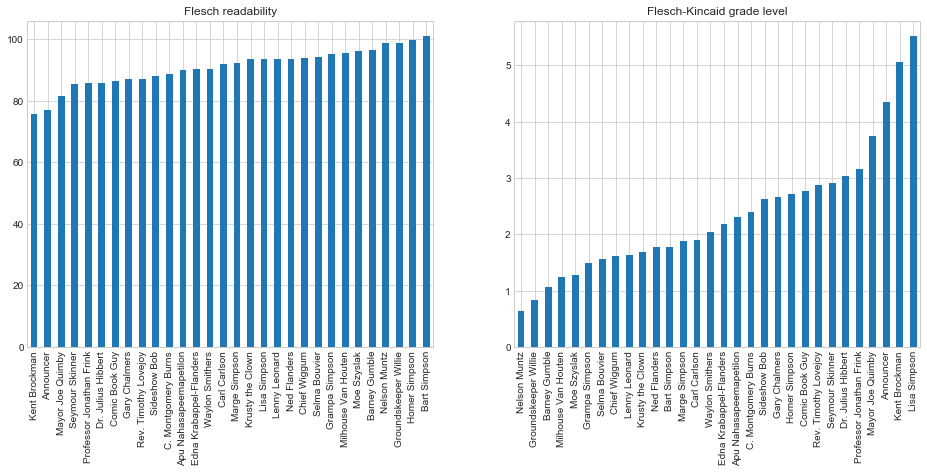

In [266]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
counts['Flesch readability'][:30].sort_values().plot(kind='bar', ax=ax[0])
ax[0].set_title('Flesch readability')
ax[0].set_xlabel('')
counts['Flesch-Kincaid grade'][:30].sort_values().plot(kind='bar', ax=ax[1])
ax[1].set_title('Flesch-Kincaid grade level')
ax[1].set_xlabel('');

In [167]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

all_speech = lines.dropna(subset=['normalized_text']).groupby('raw_character_text')['spoken_words'].agg(' '.join)

stop_words = set(stopwords.words('english'))

def proc(x):
    tokenizer = RegexpTokenizer(r'\w+')
    #print(x)
    #print(sent_tokenize(x))
    #tokens = word_tokenize(sent_tokenize(x))
    return [word.lower() for word in tokenizer.tokenize(x) if word not in stop_words]

all_speech = pd.DataFrame(all_speech.apply(lambda x: proc(x)))

all_speech['total words'] = all_speech['spoken_words'].transform(len)
all_speech['vocab size'] = all_speech['spoken_words'].transform(lambda x: len(set(x)))
all_speech['vocab:total ratio'] = all_speech['vocab size'] / all_speech['total words']

all_speech.sort_values(by='total words', ascending=False, inplace=True)

all_speech.head(10)

,spoken_words,total words,vocab size,vocab:total ratio
raw_character_text,,,,
Homer Simpson,"[there, time, careful, we, late, hey, norman, ...",175654,15466,0.088048
Marge Simpson,"[ooo, careful, homer, sorry, excuse, us, pardo...",76767,9618,0.125288
Bart Simpson,"[jingle, bells, batman, smells, robin, laid, a...",71184,9514,0.133654
Lisa Simpson,"[but, i, really, want, pony, i, really, really...",63111,10171,0.161160
C. Montgomery Burns,"[hello, i, proud, announce, able, increase, sa...",23105,6154,0.266349
Moe Szyslak,"[what, matter, homer, somebody, leave, lumpa, ...",21258,4720,0.222034
Seymour Skinner,"[wasn, wonderful, and, santas, many, lands, pr...",17804,4932,0.277016
Ned Flanders,"[just, hold, horses, son, hey, hey, simpson, d...",14953,4062,0.271651
Krusty the Clown,"[kill, well, right, go, ahead, there, someone,...",13583,3897,0.286903


In [168]:
all_speech.sort_values(by='vocab size', ascending=False).head(10)

,spoken_words,total words,vocab size,vocab:total ratio
raw_character_text,,,,
Homer Simpson,"[there, time, careful, we, late, hey, norman, ...",175654,15466,0.088048
Lisa Simpson,"[but, i, really, want, pony, i, really, really...",63111,10171,0.161160
Marge Simpson,"[ooo, careful, homer, sorry, excuse, us, pardo...",76767,9618,0.125288
Bart Simpson,"[jingle, bells, batman, smells, robin, laid, a...",71184,9514,0.133654
C. Montgomery Burns,"[hello, i, proud, announce, able, increase, sa...",23105,6154,0.266349
Seymour Skinner,"[wasn, wonderful, and, santas, many, lands, pr...",17804,4932,0.277016
Moe Szyslak,"[what, matter, homer, somebody, leave, lumpa, ...",21258,4720,0.222034
Kent Brockman,"[good, evening, springfield, krusty, clown, be...",10230,4116,0.402346
Ned Flanders,"[just, hold, horses, son, hey, hey, simpson, d...",14953,4062,0.271651


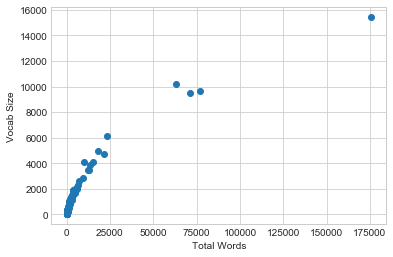

In [169]:
fig, ax = plt.subplots()
ax.scatter(all_speech['total words'], all_speech['vocab size'])
ax.set_xlabel('Total Words')
ax.set_ylabel('Vocab Size');

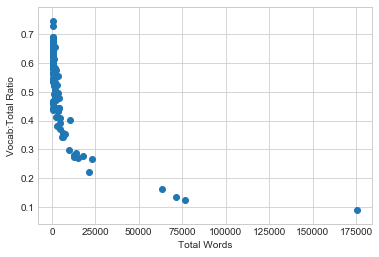

In [170]:
fig, ax = plt.subplots()
ax.scatter(all_speech.loc[all_speech['total words']>500, 'total words'],
            all_speech.loc[all_speech['total words']>500, 'vocab:total ratio'])
ax.set_xlabel('Total Words')
ax.set_ylabel('Vocab:Total Ratio');

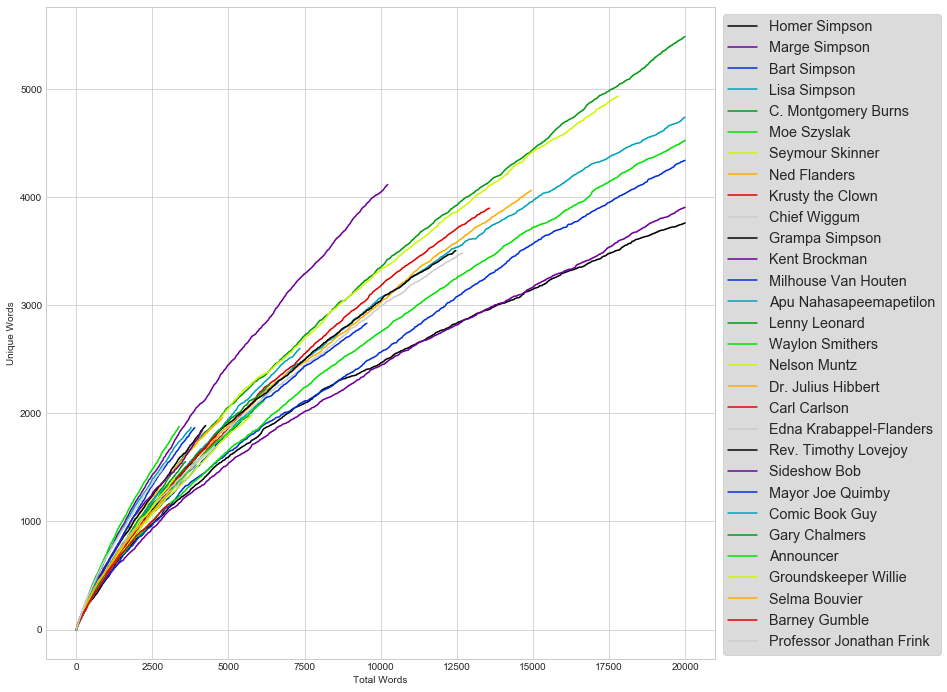

In [119]:
all_speech['new vocab curve'] = all_speech.ix[:30, 'spoken_words'].apply(lambda x: [len(set(x[:i])) for i in range(min(len(x), 20000))])

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 10))

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlabel('Total Words')
ax.set_ylabel('Unique Words')
for i in range(30):
    plt.plot(all_speech.ix[i, 'new vocab curve'], color=colors[i%10], label=str(all_speech.index[i]));
legend = ax.legend(fontsize='x-large', frameon=True, bbox_to_anchor=(1, 1));
legend.get_frame().set_facecolor('lightgrey')

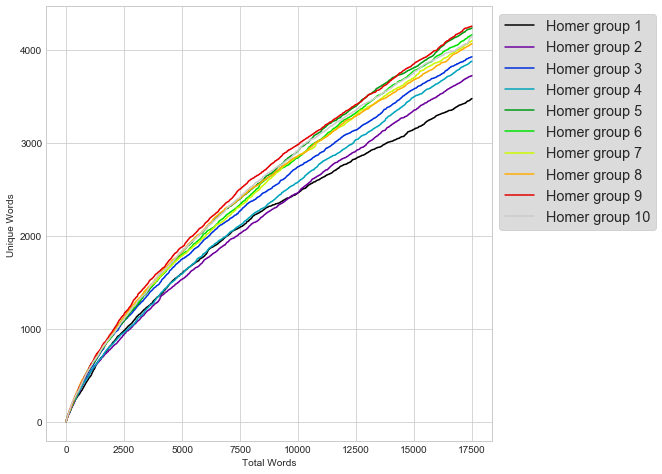

In [120]:
Homer_words = []
for j in range(10):
    Homer_words.append([len(set(all_speech.loc['Homer Simpson', 'spoken_words'][17500*j:17500*j+i])) for i in range(17500)])

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('Total Words')
ax.set_ylabel('Unique Words')
for i in range(len(Homer_words)):
    plt.plot(Homer_words[i], color=colors[i%10], label='Homer group '+str(i+1));
legend = ax.legend(fontsize='x-large', frameon=True, bbox_to_anchor=(1, 1));
legend.get_frame().set_facecolor('lightgrey')

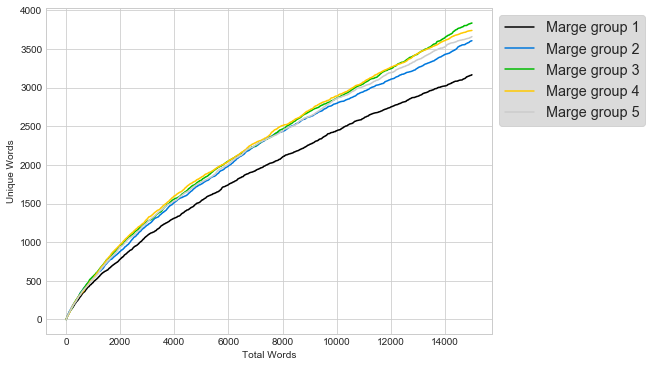

In [121]:
Marge_words = []
for j in range(5):
    Marge_words.append([len(set(all_speech.loc['Marge Simpson', 'spoken_words'][15000*j:15000*j+i])) for i in range(15000)])

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 5))

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Total Words')
ax.set_ylabel('Unique Words')
for i in range(len(Marge_words)):
    plt.plot(Marge_words[i], color=colors[i%10], label='Marge group '+str(i+1));
legend = ax.legend(fontsize='x-large', frameon=True, bbox_to_anchor=(1, 1));
legend.get_frame().set_facecolor('lightgrey')

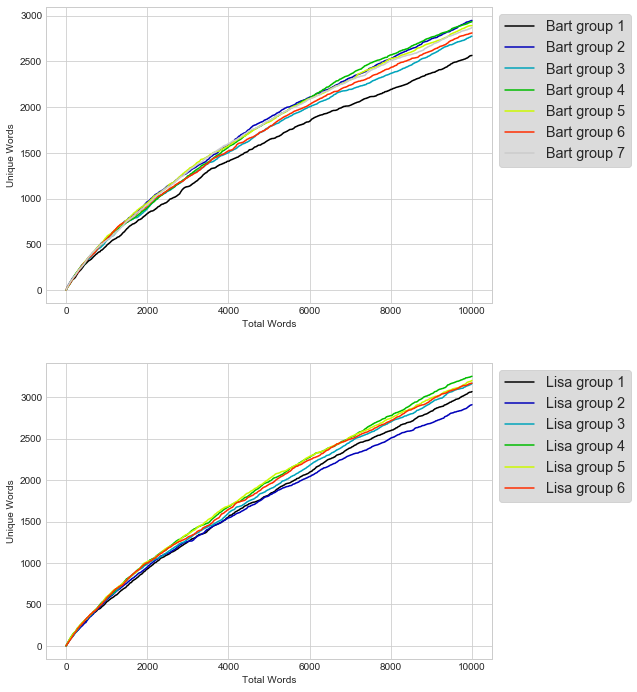

In [122]:
Bart_words = []
for j in range(7):
    Bart_words.append([len(set(all_speech.loc['Bart Simpson', 'spoken_words'][10000*j:10000*j+i])) for i in range(10000)])
    
Lisa_words = []
for j in range(6):
    Lisa_words.append([len(set(all_speech.loc['Lisa Simpson', 'spoken_words'][10000*j:10000*j+i])) for i in range(10000)])

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 7))

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax[0].set_xlabel('Total Words')
ax[0].set_ylabel('Unique Words')
for i in range(len(Bart_words)):
    ax[0].plot(Bart_words[i], color=colors[i%10], label='Bart group '+str(i+1));
legend = ax[0].legend(fontsize='x-large', frameon=True, bbox_to_anchor=(1, 1));
legend.get_frame().set_facecolor('lightgrey')
ax[1].set_xlabel('Total Words')
ax[1].set_ylabel('Unique Words')
for i in range(len(Lisa_words)):
    ax[1].plot(Lisa_words[i], color=colors[i%10], label='Lisa group '+str(i+1));
legend = ax[1].legend(fontsize='x-large', frameon=True, bbox_to_anchor=(1, 1));
legend.get_frame().set_facecolor('lightgrey')

In [5]:
import pandas as pd
from collections import Counter

In [6]:
letter_counts = Counter(lines.iloc[2]['spoken_words'])

In [7]:
letter_counts['a']

1

In [8]:
lines.head()

,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
id,,,,,,,,,,,,
1,1,0,(Street: ext. street - establishing - night),8000,FALSE,NaN,1.0,NaN,Street,NaN,NaN,NaN
2,1,1,(Car: int. car - night),8000,FALSE,NaN,2.0,NaN,Car,NaN,NaN,NaN
3,1,2,"Marge Simpson: Ooo, careful, Homer.",8000,TRUE,1,2.0,Marge Simpson,Car,"Ooo, careful, Homer.",ooo careful homer,3
4,1,3,Homer Simpson: There's no time to be careful.,10000,TRUE,2,2.0,Homer Simpson,Car,There's no time to be careful.,theres no time to be careful,6
5,1,4,Homer Simpson: We're late.,10000,TRUE,2,2.0,Homer Simpson,Car,We're late.,were late,2


In [9]:
from string import punctuation

In [10]:
punctuation_symbols = [(each) for each in list(punctuation)]
punctuation_symbols

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [11]:
lines = lines.dropna(subset = ['spoken_words']).reset_index(drop=True)

In [12]:
lines.shape

(132112, 12)

In [13]:
def remove_puncuation(d):
    for each in punctuation_symbols:
        d = d.replace(each, '')
    return d

In [14]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

In [15]:
lines['clean'] = lines['spoken_words'].apply(remove_puncuation)
lines['clean'] = lines['spoken_words'].apply(remove_digits)
lines['clean'] = lines['clean'].str.lower()

In [16]:
lines['a'] = ''
lines['b'] = ''
lines['c'] = ''
lines['d'] = ''
lines['e'] = ''
lines['f'] = ''
lines['g'] = ''
lines['h'] = ''
lines['i'] = ''
lines['j'] = ''
lines['k'] = ''
lines['l'] = ''
lines['m'] = ''
lines['n'] = ''
lines['o'] = ''
lines['p'] = ''
lines['q'] = ''
lines['r'] = ''
lines['s'] = ''
lines['t'] = ''
lines['u'] = ''
lines['v'] = ''
lines['w'] = ''
lines['x'] = ''
lines['y'] = ''
lines['z'] = ''

In [17]:
import pandas as pd
from collections import Counter
a = ['a', 'a', 'a', 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'e', 'e', 'e', 'e', 'e']
letter_counts = Counter(a)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df

,0
a,4
b,2
c,3
d,1
e,5


In [18]:
from collections import Counter

problems = []

for index, row in lines.iterrows():
    try:
        lines.set_value(index, 'a', Counter(row['clean'])['a'])
        lines.set_value(index, 'b', Counter(row['clean'])['b'])
        lines.set_value(index, 'c', Counter(row['clean'])['c'])
        lines.set_value(index, 'd', Counter(row['clean'])['d'])
        lines.set_value(index, 'e', Counter(row['clean'])['e'])
        lines.set_value(index, 'f', Counter(row['clean'])['f'])
        lines.set_value(index, 'g', Counter(row['clean'])['g'])
        lines.set_value(index, 'h', Counter(row['clean'])['h'])
        lines.set_value(index, 'i', Counter(row['clean'])['i'])
        lines.set_value(index, 'j', Counter(row['clean'])['j'])
        lines.set_value(index, 'k', Counter(row['clean'])['k'])
        lines.set_value(index, 'l', Counter(row['clean'])['l'])
        lines.set_value(index, 'm', Counter(row['clean'])['m'])
        lines.set_value(index, 'n', Counter(row['clean'])['n'])
        lines.set_value(index, 'o', Counter(row['clean'])['o'])
        lines.set_value(index, 'p', Counter(row['clean'])['p'])
        lines.set_value(index, 'q', Counter(row['clean'])['q'])
        lines.set_value(index, 'r', Counter(row['clean'])['r'])
        lines.set_value(index, 's', Counter(row['clean'])['s'])
        lines.set_value(index, 't', Counter(row['clean'])['t'])
        lines.set_value(index, 'u', Counter(row['clean'])['u'])
        lines.set_value(index, 'v', Counter(row['clean'])['v'])
        lines.set_value(index, 'w', Counter(row['clean'])['w'])
        lines.set_value(index, 'x', Counter(row['clean'])['x'])
        lines.set_value(index, 'y', Counter(row['clean'])['y'])
        lines.set_value(index, 'z', Counter(row['clean'])['z'])
    except:
        problems.append(row)

In [23]:
lines.columns.tolist()[12]

['episode_id',
 'number',
 'raw_text',
 'timestamp_in_ms',
 'speaking_line',
 'character_id',
 'location_id',
 'raw_character_text',
 'raw_location_text',
 'spoken_words',
 'normalized_text',
 'word_count',
 'clean',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [29]:
df = lines.iloc[:,13:(26+13)]

In [49]:
df.head()

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
0,1,0,1,0,2,1,0,1,0,0,...,0,2,0,0,1,0,0,0,0,0
1,1,1,1,0,5,1,0,1,1,0,...,0,2,1,3,1,0,0,0,0,0
2,1,0,0,0,3,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
3,1,0,1,1,3,0,0,0,0,0,...,0,3,3,0,2,0,0,1,1,0
4,3,0,1,6,11,2,6,8,3,0,...,0,5,3,3,2,0,3,1,3,0


In [31]:
dataDict = {
    
'a': lines['a'].sum(),
'b': lines['b'].sum(),
'c': lines['c'].sum(),
'd': lines['d'].sum(),
'e': lines['e'].sum(),
'f': lines['f'].sum(),
'g': lines['g'].sum(),
'h': lines['h'].sum(),
'i': lines['i'].sum(),
'j': lines['j'].sum(),
'k': lines['k'].sum(),
'l': lines['l'].sum(),
'm': lines['m'].sum(),
'n': lines['n'].sum(),
'o': lines['o'].sum(),
'p': lines['p'].sum(),
'q': lines['q'].sum(),
'r': lines['r'].sum(),
's': lines['s'].sum(),
't': lines['t'].sum(),
'u': lines['u'].sum(),
'v': lines['v'].sum(),
'w': lines['w'].sum(),
'x': lines['x'].sum(),
'y': lines['y'].sum(),
'z': lines['z'].sum()
}

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [95]:
import json
r = json.dumps(dataDict)